In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '8'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
from train import get_args, load_model, IsMovingTarget
import datasets as raft_datasets
import utils.flow_viz as flow_viz

def set_args(args_dict={}):
    args = get_args("")
    for k,v in args_dict.items():
        args.__setattr__(k, v)
    return args

def tensor_to_arr(tensor, ex=0):
    if len(tensor.shape) == 4:
        tensor = tensor[ex]
    return tensor.detach().permute(1, 2, 0).cpu().numpy()

def viz(tensor, ex=0):
    im = tensor_to_arr(tensor, ex)
    if im.max() > 2.0:
        im = im / 255.0
    plt.imshow(im)
    

/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:696: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  collections.MutableMapping.register(ParseResults)
/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:2273: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif isinstance( exprs, collections.Sequence ):
/home/dbear/tenv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:568: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

## Load a motion model and dataset

In [4]:
# motion_net = load_model('../checkpoints/20000_motion-tdw-bs8-small-fullplay-tr0-8.pth',
#                  train=False, cuda=True, freeze_bn=False, small=True, gpus=[0])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
tdw_dataset = raft_datasets.TdwFlowDataset(
    root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
#     root='/mnt/fs5/dbear/tdw_datasets/playroom_large_v3/',
    dataset_names=['model_split_4'],    
#     dataset_names=['model_split_%d' % split for split in range(4)],
    split='training',
    filepattern="*",
#     test_filepattern="0*[0-4]",
    test_filepattern="*9",
    min_start_frame=6,
    max_start_frame=6,
    scale_to_pixels=True,
    get_gt_flow=True,
    get_backward_frame=True
)
print(len(tdw_dataset))
print(tdw_dataset.is_test)

1250
False


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Create a training target for motion

In [6]:
import dorsalventral.models.targets as targets
import dorsalventral.vis_utils as vis_utils

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
IM = targets.IsMovingTarget(3, thresh=None, normalize_error=False, normalize_features=False).cuda()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
ex = 41
img1, img2, img0 = tdw_dataset[ex][:3]
x = torch.stack([img0, img1, img2], 0).float() / 255.
target = IM(x[None].cuda())
# _, pred = motion_net(img1[None].cuda(), img2[None].cuda(), test_mode=True, iters=12)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


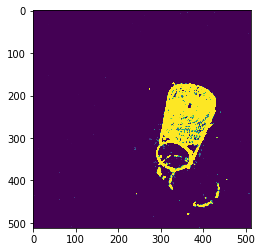

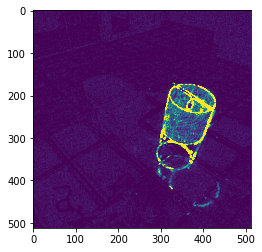

In [49]:
mean = F.relu(target[0]).mean(dim=(-2,-1), keepdim=True)
vis_utils.imshow((F.relu(target[0]) - mean) / mean, vmin=0, vmax=1.0)
vis_utils.imshow(F.relu(target[0]), vmin=0, vmax=0.025)


In [35]:
target[0].mean()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor(0.0007, device='cuda:0')

# Train

In [4]:
mprop = load_model(None, model_class='prop', 
                   small=False, 
                   cuda=True, 
                   train=True, 
                   num_sample_points=2048,
                   affinity_nonlinearity='softmax',
                   motion_thresh=0.25,
                   binarize_motion=True,
                   num_propagation_iters=50)

def get_motion_target(t):
    t = F.relu(t)
    mean = t.mean((-2,-1), True).clamp(min=1e-9)
    return F.relu((t - mean) / mean)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [119]:
num_steps = 100
print_every = 1
raft_iters = 12
scale = 100.0
optim = torch.optim.Adam(mprop.parameters(), lr=0.0001)
loss_fn = nn.BCELoss(reduction='none')
motion_thresh = 0.01

ex = 41
img1, img2, img0 = tdw_dataset[ex][:3]
x = torch.stack([img0, img1, img2], 0).float() / 255.
target = IM(x[None].cuda())

# motion_target = (get_motion_target(target[0]) > motion_thresh).float()
motion_target = (target[0] > motion_thresh).float()


x1, x2 = img1[None].cuda(), img2[None].cuda()

train_loss = []
for step in range(num_steps+1):
    
    optim.zero_grad()
    preds_list = mprop(x1, x2, test_mode=False, iters=raft_iters)
    loss_list = [scale * loss_fn(pred.clamp(max=1.), motion_target).mean() for pred in preds_list]
    loss = sum(loss_list)
    loss.backward()
    optim.step()
    
    train_loss.append(loss.item())
    if (step % print_every) == 0:
        print("step: %d, loss_first, loss_last, loss_total ---- %.3f, %.3f, %.3f" % 
              (step, loss_list[0].item(), loss_list[-1].item(), loss.item()))
    

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


step: 0, loss_first, loss_last, loss_total ---- 46.634, 272.009, 3042.275
step: 1, loss_first, loss_last, loss_total ---- 18.685, 273.666, 3029.015
step: 2, loss_first, loss_last, loss_total ---- 19.368, 273.666, 3029.699
step: 3, loss_first, loss_last, loss_total ---- 18.466, 273.666, 3028.797
step: 4, loss_first, loss_last, loss_total ---- 15.917, 273.666, 3026.248
step: 5, loss_first, loss_last, loss_total ---- 13.152, 273.666, 3023.483
step: 6, loss_first, loss_last, loss_total ---- 12.578, 273.666, 3022.909
step: 7, loss_first, loss_last, loss_total ---- 12.693, 273.666, 3023.023
step: 8, loss_first, loss_last, loss_total ---- 10.706, 273.666, 3021.036
step: 9, loss_first, loss_last, loss_total ---- 10.262, 273.666, 3020.593
step: 10, loss_first, loss_last, loss_total ---- 10.112, 273.666, 3020.443
step: 11, loss_first, loss_last, loss_total ---- 9.243, 273.666, 3019.573
step: 12, loss_first, loss_last, loss_total ---- 8.170, 273.666, 3018.500
step: 13, loss_first, loss_last, loss

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


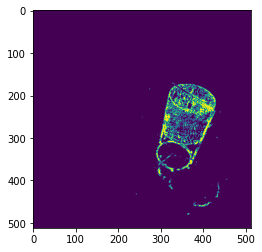

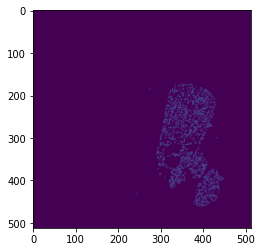

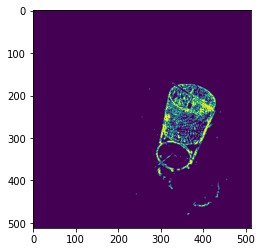

In [68]:
vis_utils.imshow(preds_list[0])
vis_utils.imshow(preds_list[-1])
vis_utils.imshow(motion_target)

In [69]:
mprop.module.propagator.thresh = 0.25
fire, motion = mprop(x1, x2, test_mode=True)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


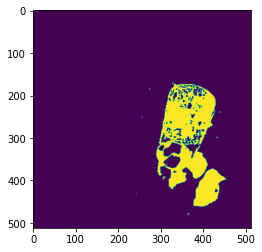

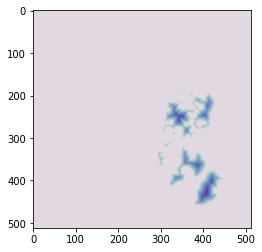

In [70]:
vis_utils.imshow(motion)
vis_utils.imshow(fire, cmap='twilight', vmin=0, vmax=50)

## Now train on the larger dataset

In [6]:
import dorsalventral.models.targets as targets
import dorsalventral.vis_utils as vis_utils

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
tdw_dataset = raft_datasets.TdwFlowDataset(
    root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
#     root='/mnt/fs5/dbear/tdw_datasets/playroom_large_v3/',
    dataset_names=['model_split_4'],    
#     dataset_names=['model_split_%d' % split for split in range(4)],
    split='training',
    filepattern="*",
#     test_filepattern="0*[0-4]",
    test_filepattern="*9",
    min_start_frame=6,
    max_start_frame=6,
    scale_to_pixels=True,
    get_gt_flow=True,
    get_backward_frame=True
)
print(len(tdw_dataset))
print(tdw_dataset.is_test)

1250
False


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# mprop = load_model(None, model_class='prop', 
#                    small=True, 
#                    cuda=True, 
#                    train=True, 
#                    num_sample_points=2048,
#                    affinity_nonlinearity='softmax',
#                    motion_thresh=0.5,
#                    binarize_motion=True,
#                    num_propagation_iters=50)

mclass_teacher = load_model(None, model_class='motion', 
                   small=True, 
                   cuda=True, 
                   train=True)


mprop_student = load_model(None, model_class='prop', 
                   small=True, 
                   cuda=True, 
                   train=True, 
                   num_sample_points=128,
                   affinity_nonlinearity='softmax',
                   motion_thresh=0.5,
                   binarize_motion=True,
                   num_propagation_iters=50)

IM = targets.IsMovingTarget(warp_radius=3, 
                            thresh=None, 
                            normalize_error=False, 
                            normalize_features=False).cuda()



raft_iters=12
loss_fn = nn.BCELoss(reduction='none')

def get_motion_target(img0, img1, img2, thresh=0.01):
    video = torch.stack([img0, img1, img2], 1).float() / 255.
    target = (IM(video)[:,0] > thresh).float()
    return target

def get_teacher_target(teacher, img0, img1, img2, thresh=0.25):
    motion_fwd = teacher(img1, img2, test_mode=False, iters=raft_iters)[-1]
#     motion_bck = teacher(img1, img0, test_mode=False, iters=raft_iters)[0]
    target = (torch.sigmoid(motion_fwd).detach() > thresh).float()
    return target

def train_step(data, model, optimizer, teacher=None, thresh=0.01, motion_scale=1.0, affinity_scale=1.0):
    
    optimizer.zero_grad()
    img1, img2, img0 = [d.cuda() for d in data[:3]]
    if teacher is None:
        target = get_motion_target(img0, img1, img2, thresh=target_thresh)
    else:
        target = get_teacher_target(teacher, img0, img1, img2, thresh=target_thresh)
    preds_list = model(img1, img2, test_mode=False, iters=raft_iters)
    
    if teacher is None:
        loss_list = [loss_fn(torch.sigmoid(pred), target).mean() for pred in preds_list]
        loss = motion_scale * (sum(loss_list) / len(loss_list))
    else:
        loss_list = [loss_fn(pred.clamp(max=1.), target).mean() for pred in preds_list]
        loss = motion_scale * loss_list[0] + affinity_scale * (sum(loss_list[1:]) / len(loss_list[1:]))
    loss.backward()
    optimizer.step()
    
    return (loss, loss_list)

def val_step(data, model, test_mode=True, motion_thresh=None):
    
    img1, img2, img0 = [d[None].cuda() for d in data[:3]]
    target = get_motion_target(img0, img1, img2, thresh=target_thresh)
    if motion_thresh is not None:
        model.module.propagator.thresh = motion_thresh
    preds = model(img1, img2, test_mode=test_mode, iters=raft_iters)
    return (preds, target)
    

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
num_epochs = 25
num_steps = None
print_every = 10

rnd = 0

if rnd == 0:
    m_scale = 100.0
    a_scale = 0.
    teacher = None
    student = mclass_teacher
    target_thresh = 0.01
elif rnd == 1:
    m_scale = 100.
    a_scale = 100.
    teacher = mclass_teacher
    student = mprop_student
    target_thresh = 0.25

batch_size = 4
trainloader = torch.utils.data.DataLoader(tdw_dataset, 
                                          batch_size=batch_size,
                                          shuffle=True,
                                          pin_memory=False,
                                          num_workers=4,
                                          drop_last=True)
opt = torch.optim.Adam(student.parameters(), lr=0.0001)

for epoch in range(num_epochs):
    for step, data in enumerate(trainloader):
        if step == num_steps:
            break
        
        loss, loss_list = train_step(data=data, model=student, optimizer=opt, teacher=teacher,
                                     thresh=target_thresh,
                                     motion_scale=m_scale, affinity_scale=a_scale)
        if (step % print_every) == 0:
            print("epoch %d / step %d ---- loss first %.3f ---- loss last %.3f ---- loss total %.3f" % 
                  (epoch, step, loss_list[0].item(), loss_list[-1].item(), loss.item()))
            
    if step == num_steps:
        break
        

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


epoch 0 / step 0 ---- loss first 0.023 ---- loss last 0.023 ---- loss total 2.332
epoch 0 / step 10 ---- loss first 0.052 ---- loss last 0.054 ---- loss total 5.288
epoch 0 / step 20 ---- loss first 0.119 ---- loss last 0.119 ---- loss total 11.897
epoch 0 / step 30 ---- loss first 0.046 ---- loss last 0.045 ---- loss total 4.509
epoch 0 / step 40 ---- loss first 0.028 ---- loss last 0.028 ---- loss total 2.765
epoch 0 / step 50 ---- loss first 0.020 ---- loss last 0.020 ---- loss total 1.991
epoch 0 / step 60 ---- loss first 0.030 ---- loss last 0.030 ---- loss total 3.017
epoch 0 / step 70 ---- loss first 0.111 ---- loss last 0.111 ---- loss total 11.011
epoch 0 / step 80 ---- loss first 0.082 ---- loss last 0.082 ---- loss total 8.178
epoch 0 / step 90 ---- loss first 0.024 ---- loss last 0.025 ---- loss total 2.470
epoch 0 / step 100 ---- loss first 0.081 ---- loss last 0.078 ---- loss total 7.911
epoch 0 / step 110 ---- loss first 0.041 ---- loss last 0.041 ---- loss total 4.133
e

epoch 3 / step 20 ---- loss first 0.104 ---- loss last 0.103 ---- loss total 10.268
epoch 3 / step 30 ---- loss first 0.040 ---- loss last 0.040 ---- loss total 3.943
epoch 3 / step 40 ---- loss first 0.043 ---- loss last 0.042 ---- loss total 4.201
epoch 3 / step 50 ---- loss first 0.068 ---- loss last 0.068 ---- loss total 6.784
epoch 3 / step 60 ---- loss first 0.048 ---- loss last 0.048 ---- loss total 4.828
epoch 3 / step 70 ---- loss first 0.039 ---- loss last 0.039 ---- loss total 3.861
epoch 3 / step 80 ---- loss first 0.048 ---- loss last 0.048 ---- loss total 4.817
epoch 3 / step 90 ---- loss first 0.011 ---- loss last 0.011 ---- loss total 1.133
epoch 3 / step 100 ---- loss first 0.036 ---- loss last 0.036 ---- loss total 3.628
epoch 3 / step 110 ---- loss first 0.009 ---- loss last 0.009 ---- loss total 0.913
epoch 3 / step 120 ---- loss first 0.100 ---- loss last 0.104 ---- loss total 10.300
epoch 3 / step 130 ---- loss first 0.028 ---- loss last 0.029 ---- loss total 2.82

In [31]:
ex = 5
teacher_preds, target = val_step(tdw_dataset[ex], mclass_teacher, test_mode=True, motion_thresh=None)
preds, target = val_step(tdw_dataset[ex], mprop_student, test_mode=True, motion_thresh=0.5)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


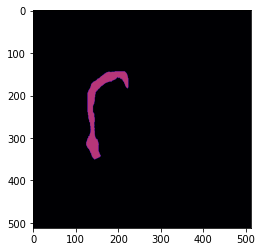

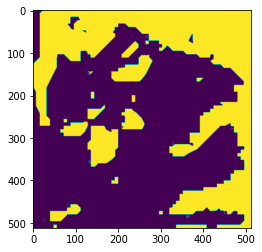

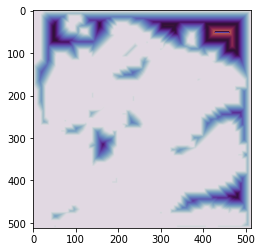

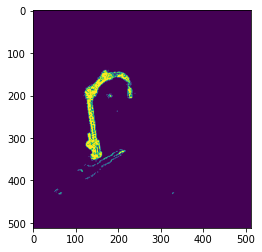

In [32]:
vis_utils.imshow(torch.sigmoid(teacher_preds[-1]) > 0.25, cmap='magma', vmin=0, vmax=preds[-1].amax()+1)
vis_utils.imshow(preds[-1], cmap='magma')
vis_utils.imshow(preds[0], cmap='twilight', vmin=0, vmax=preds[0].amax()*1.3)

vis_utils.imshow(target)

In [27]:
ex = 1
img1, img2, img0 = [d[None].cuda() for d in tdw_dataset[ex][:3]]
# target = get_teacher_target(mprop, img0, img1, img2, thresh=0.25)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


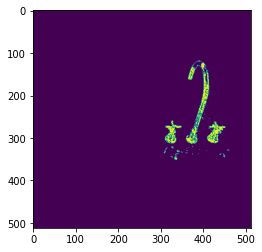

In [28]:
vis_utils.imshow(target)